In [1]:
import tensorflow as tf
gpu = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpu[0], True)
print(gpu[0])

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


# 1. Import Libraries

In [2]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from geopy.distance import distance

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import SGD, Adam,  RMSprop, Nadam
from tensorflow.keras.layers import Dense, Flatten,  LSTM, GRU, LeakyReLU, Dropout, Bidirectional

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import  MinMaxScaler, PowerTransformer

from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import (
    AdaBoostRegressor,
    BaggingRegressor,
    ExtraTreesRegressor,
    GradientBoostingRegressor, 
    HistGradientBoostingRegressor,
    RandomForestRegressor,
    StackingRegressor,
)
from xgboost import XGBRegressor

from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly


# 2. Load Data

In [41]:
data = pd.read_csv('../Dataset/CarPrice.csv').dropna()
data

,car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,...,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,1,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,2,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
2,3,1,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0
3,4,2,audi 100 ls,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0
4,5,2,audi 100ls,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200,201,-1,volvo 145e (sw),gas,std,four,sedan,rwd,front,109.1,...,141,mpfi,3.78,3.15,9.5,114,5400,23,28,16845.0
201,202,-1,volvo 144ea,gas,turbo,four,sedan,rwd,front,109.1,...,141,mpfi,3.78,3.15,8.7,160,5300,19,25,19045.0
202,203,-1,volvo 244dl,gas,std,four,sedan,rwd,front,109.1,...,173,mpfi,3.58,2.87,8.8,134,5500,18,23,21485.0
203,204,-1,volvo 246,diesel,turbo,four,sedan,rwd,front,109.1,...,145,idi,3.01,3.40,23.0,106,4800,26,27,22470.0


# 3. Initial Analysis

### 3.1. Metadata

In [48]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   car_ID            205 non-null    int64  
 1   symboling         205 non-null    int64  
 2   CarName           205 non-null    int16  
 3   fueltype          205 non-null    int16  
 4   aspiration        205 non-null    int16  
 5   doornumber        205 non-null    int16  
 6   carbody           205 non-null    int16  
 7   drivewheel        205 non-null    int16  
 8   enginelocation    205 non-null    int16  
 9   wheelbase         205 non-null    float64
 10  carlength         205 non-null    float64
 11  carwidth          205 non-null    float64
 12  carheight         205 non-null    float64
 13  curbweight        205 non-null    int64  
 14  enginetype        205 non-null    int16  
 15  cylindernumber    205 non-null    int16  
 16  enginesize        205 non-null    int64  
 1

In [43]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
car_ID,205.0,103.000000,59.322565,1.00,52.00,103.00,154.00,205.00
symboling,205.0,0.834146,1.245307,-2.00,0.00,1.00,2.00,3.00
wheelbase,205.0,98.756585,6.021776,86.60,94.50,97.00,102.40,120.90
carlength,205.0,174.049268,12.337289,141.10,166.30,173.20,183.10,208.10
carwidth,205.0,65.907805,2.145204,60.30,64.10,65.50,66.90,72.30
carheight,205.0,53.724878,2.443522,47.80,52.00,54.10,55.50,59.80
curbweight,205.0,2555.565854,520.680204,1488.00,2145.00,2414.00,2935.00,4066.00
enginesize,205.0,126.907317,41.642693,61.00,97.00,120.00,141.00,326.00
boreratio,205.0,3.329756,0.270844,2.54,3.15,3.31,3.58,3.94
stroke,205.0,3.255415,0.313597,2.07,3.11,3.29,3.41,4.17


In [44]:
data.isnull().sum()

car_ID              0
symboling           0
CarName             0
fueltype            0
aspiration          0
doornumber          0
carbody             0
drivewheel          0
enginelocation      0
wheelbase           0
carlength           0
carwidth            0
carheight           0
curbweight          0
enginetype          0
cylindernumber      0
enginesize          0
fuelsystem          0
boreratio           0
stroke              0
compressionratio    0
horsepower          0
peakrpm             0
citympg             0
highwaympg          0
price               0
dtype: int64

In [10]:
data.duplicated().sum()

0

### 3.2. Columns Processing

In [ ]:
# def change_dtypes(data):
#     data["ForecastWindProduction"] = pd.to_numeric(data["ForecastWindProduction"], errors= 'coerce')
#     data["SystemLoadEA"] = pd.to_numeric(data["SystemLoadEA"], errors= 'coerce')
#     data["SMPEA"] = pd.to_numeric(data["SMPEA"], errors= 'coerce')
#     data["ORKTemperature"] = pd.to_numeric(data["ORKTemperature"], errors= 'coerce')
#     data["ORKWindspeed"] = pd.to_numeric(data["ORKWindspeed"], errors= 'coerce')
#     data["CO2Intensity"] = pd.to_numeric(data["CO2Intensity"], errors= 'coerce')
#     data["ActualWindProduction"] = pd.to_numeric(data["ActualWindProduction"], errors= 'coerce')
#     data["SystemLoadEP2"] = pd.to_numeric(data["SystemLoadEP2"], errors= 'coerce')
#     data["SMPEP2"] = pd.to_numeric(data["SMPEP2"], errors= 'coerce')
#     return data

# data = change_dtypes(data)

In [49]:
numerical_columns = [column_name for column_name in data.columns if data[column_name].dtype != 'object']
categorical_columns = [column_name for column_name in data.columns if data[column_name].dtype == 'object']

print(f'Numerical Columns Train   : {numerical_columns}')
print(f'Categorical Columns Train : {categorical_columns}')

Numerical Columns Train   : ['car_ID', 'symboling', 'CarName', 'fueltype', 'aspiration', 'doornumber', 'carbody', 'drivewheel', 'enginelocation', 'wheelbase', 'carlength', 'carwidth', 'carheight', 'curbweight', 'enginetype', 'cylindernumber', 'enginesize', 'fuelsystem', 'boreratio', 'stroke', 'compressionratio', 'horsepower', 'peakrpm', 'citympg', 'highwaympg', 'price']
Categorical Columns Train : []


In [46]:
LE = LabelEncoder()

for idx, column in enumerate(categorical_columns):
    data[column] =  LE.fit_transform(data[column])
    data[column] = data[column].astype('int16')

In [47]:
data

,car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,...,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,1,3,2,1,0,1,0,2,0,88.6,...,130,5,3.47,2.68,9.0,111,5000,21,27,13495.0
1,2,3,3,1,0,1,0,2,0,88.6,...,130,5,3.47,2.68,9.0,111,5000,21,27,16500.0
2,3,1,1,1,0,1,2,2,0,94.5,...,152,5,2.68,3.47,9.0,154,5000,19,26,16500.0
3,4,2,4,1,0,0,3,1,0,99.8,...,109,5,3.19,3.40,10.0,102,5500,24,30,13950.0
4,5,2,5,1,0,0,3,0,0,99.4,...,136,5,3.19,3.40,8.0,115,5500,18,22,17450.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200,201,-1,139,1,0,0,3,2,0,109.1,...,141,5,3.78,3.15,9.5,114,5400,23,28,16845.0
201,202,-1,138,1,1,0,3,2,0,109.1,...,141,5,3.78,3.15,8.7,160,5300,19,25,19045.0
202,203,-1,140,1,0,0,3,2,0,109.1,...,173,5,3.58,2.87,8.8,134,5500,18,23,21485.0
203,204,-1,142,0,1,0,3,2,0,109.1,...,145,3,3.01,3.40,23.0,106,4800,26,27,22470.0


# 4. EDA

<Axes: xlabel='price'>

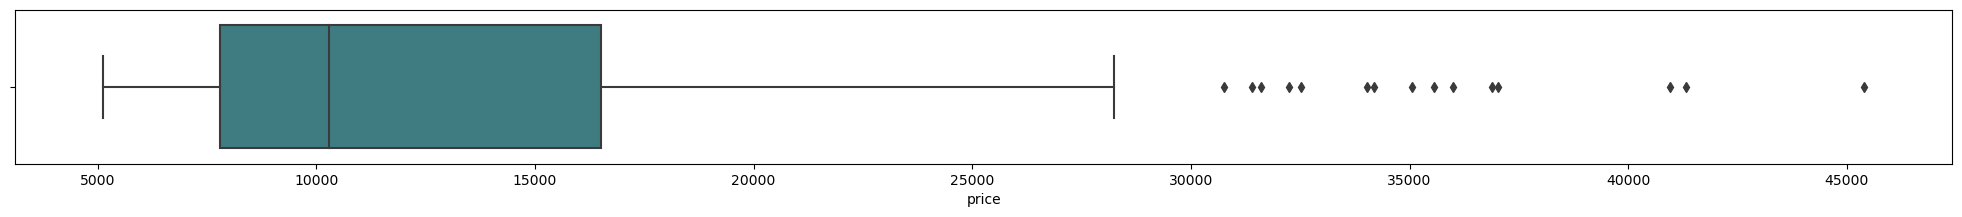

In [50]:
fig, ax = plt.subplots(figsize=(25, 2))
sns.boxplot(x=data['price'], palette="crest")

In [51]:
print(data['price'].quantile(0.25))
print(data['price'].quantile(0.75))

7788.0
16503.0


<Axes: xlabel='SMPEP2'>

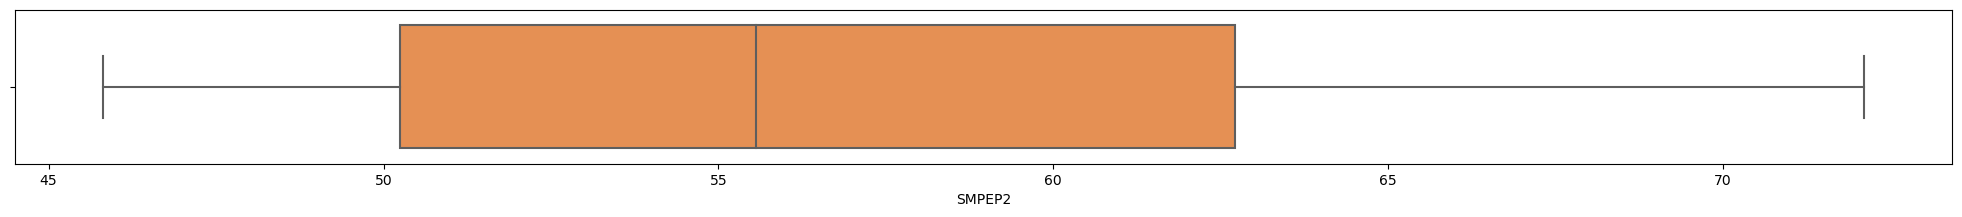

In [11]:
Q1 = data['SMPEP2'].quantile(.25)
Q3 = data['SMPEP2'].quantile(.75)

data = data[(data['SMPEP2'] > Q1) & (data['SMPEP2'] < Q3)]

fig, axes = plt.subplots(figsize=(25, 2))
sns.boxplot(x = data['SMPEP2'], palette="Oranges")

Text(0.5, 1.0, 'Correlation Matrix')

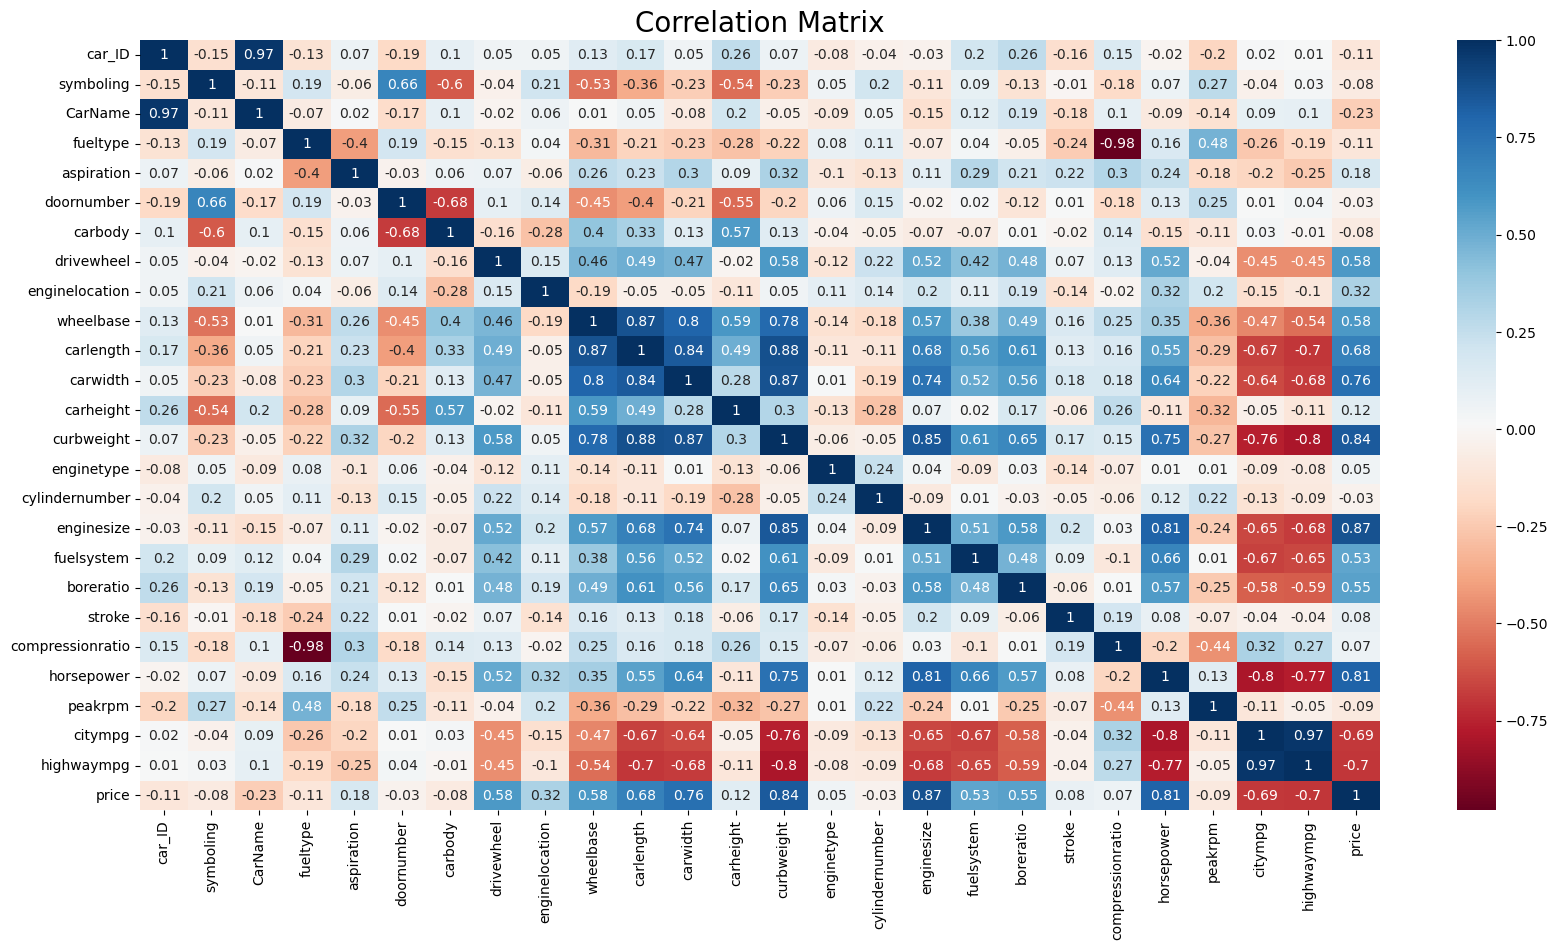

In [55]:
corr_data = data.corr().round(2)

plt.figure(figsize=(20, 10))
sns.heatmap(corr_data, annot=True, cmap='RdBu')
plt.title("Correlation Matrix", size=20)

# 5. Regression Algoritms

In [71]:
X = data.drop(columns=['price'])
# X = data[["Day", "Month", 'Holiday', 'HolidayFlag',
#         "ForecastWindProduction", "SystemLoadEA", 
#         "SMPEA", "ORKTemperature", "ORKWindspeed", "CO2Intensity", 
#         "ActualWindProduction", "SystemLoadEP2"]]
Y = data['price']

X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size = 0.9, random_state = 42)

scalar = PowerTransformer(method='yeo-johnson', standardize=True)
X_train = scalar.fit_transform(X_train)
X_test = scalar.fit_transform(X_test)

print(X_train.shape)
print(X_test.shape)

(184, 25)
(21, 25)


In [125]:
adaboost = AdaBoostRegressor(n_estimators = 100, random_state = 42)
bagging = BaggingRegressor(n_jobs = -1)
extraTrees = ExtraTreesRegressor(max_depth = 100, n_jobs = -1, random_state = 42)
gradient = GradientBoostingRegressor(max_depth = 100, n_estimators = 100, learning_rate = .01,  random_state = 0)
randomForest = RandomForestRegressor(max_depth = 100, random_state = 42, n_jobs = -1)
histGradient = HistGradientBoostingRegressor()
XGB = XGBRegressor(n_jobs = -1)
knn = KNeighborsRegressor(n_jobs = -1)
decisionTree = DecisionTreeRegressor( max_depth = 100, random_state = 42)

model = StackingRegressor([
    ('extraTrees', extraTrees),
    ('knn', knn),
    ('histGradient', histGradient),
    ('adaboost', adaboost),
    # ('bagging', bagging),
    # ('randomforest', randomForest),
    # ('XGB', XGB),
    # ('decisionTree', decisionTree),
    # ('gradient', gradient),
], n_jobs=-1)

In [126]:
model.fit(X_train, y_train)

StackingRegressor(estimators=[('extraTrees',
                               ExtraTreesRegressor(max_depth=100, n_jobs=-1,
                                                   random_state=42)),
                              ('knn', KNeighborsRegressor(n_jobs=-1)),
                              ('histGradient', HistGradientBoostingRegressor()),
                              ('adaboost',
                               AdaBoostRegressor(n_estimators=100,
                                                 random_state=42))],
                  n_jobs=-1)

In [127]:
print("Train Score        :",round((model.score(X_train, y_train)*100), 2),'%')
print("Test Score         :",round((model.score(X_test, y_test)*100), 2),'%')

y_pred = model.predict(X_test)

print("R Squared Error    :",round(r2_score(y_test, y_pred), 2))
print("Mean Squared Error :",round(mean_squared_error(y_test, y_pred), 2))

Train Score        : 99.16 %
Test Score         : 95.56 %
R Squared Error    : 0.96
Mean Squared Error : 3559969.02


In [128]:
train_predictions = model.predict(X_test).flatten()

train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_test})
train_results['Diff'] = abs(train_results['Actuals'] - train_results['Train Predictions'])
print(train_results.head(5))
print(train_results['Diff'].mean(), '-', (train_results['Diff'].sum()))

     Train Predictions    Actuals         Diff
15        33477.960876  30760.000  2717.960876
9         20044.938964  17859.167  2185.771964
100        8426.421027   9549.000  1122.578973
132       14073.827691  11850.000  2223.827691
68        22554.003532  28248.000  5693.996468
1434.1927674944218 - 30118.04811738286


In [129]:
print(train_results['Diff'].mean())

1434.1927674944218


# 6. Neural Network

In [56]:
X = data.drop(columns=['price'])
# X = data[["Day", "Month", 'Holiday', 'HolidayFlag',
#         "ForecastWindProduction", "SystemLoadEA", 
#         "SMPEA", "ORKTemperature", "ORKWindspeed", "CO2Intensity", 
#         "ActualWindProduction", "SystemLoadEP2"]]
Y = data['price']

X_train, X_val, y_train, y_val = train_test_split(X, Y, train_size=0.9, random_state = 42)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, train_size=0.78, random_state = 42)

scalar = PowerTransformer(method='yeo-johnson', standardize=True)
# scalar = MinMaxScaler(feature_range=(0,1))
X_train = scalar.fit_transform(X_train)
X_test = scalar.fit_transform(X_test)
X_val = scalar.fit_transform(X_val)

print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(143, 25)
(41, 25)
(21, 25)


In [60]:
def DNN_Model():
    model = Sequential()
    model.add(Dense(1024, activation='relu', kernel_initializer='he_uniform', input_shape=(X_train.shape[1],)))
    # model.add(Dropout(0.5))
    # model.add(Dense(256, activation='relu'))
    # model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    # model.add(Dropout(0.5))
    model.add(Dense(1, activation='linear', kernel_initializer='he_uniform'))
    
    return model

def LSTM_Model():
    model = Sequential()
    model.add(LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    # model.add(LSTM(64))
    model.add(Dense(32, activation='relu'))
    # model.add(Dropout(0.2))
    # model.add(Dropout(0.5))
    # model.add(Dense(16, activation='relu'))
    model.add(Dense(1))
    return model

def GRU_Model():
    model = Sequential()
    model.add(GRU(128, activation ='tanh', recurrent_activation ='sigmoid', recurrent_dropout = 0, unroll=False, use_bias=True, reset_after=True, return_sequences=True, input_shape = (X_train.shape[1],1)))
    model.add(GRU(64, activation ='tanh', recurrent_activation ='sigmoid', recurrent_dropout = 0, unroll=False, use_bias=True, reset_after=True, return_sequences=True))
    model.add(GRU(32, activation ='tanh', recurrent_activation ='sigmoid', recurrent_dropout = 0, unroll=False, use_bias=True, reset_after=True))
    # model.add(Dense(128, activation='relu'))
    # model.add(Dense(64, activation='relu'))
    model.add(Dense(1))
    return model

# model = DNN_Model()
# model = LSTM_Model()
model = GRU_Model()

model.summary()

# opt = SGD(learning_rate=0.01, momentum=0.9)
opt = Adam(learning_rate = 0.0001)

# model.compile(loss='mse', optimizer=opt, metrics=['mse'])
model.compile(loss='mae', optimizer = opt)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_3 (GRU)                 (None, 25, 128)           50304     
                                                                 
 gru_4 (GRU)                 (None, 25, 64)            37248     
                                                                 
 gru_5 (GRU)                 (None, 32)                9408      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 96,993
Trainable params: 96,993
Non-trainable params: 0
_________________________________________________________________


In [61]:
num_epoch = 10
batch_size = 32

history = model.fit(X_train, y_train, 
                    batch_size = batch_size, epochs = num_epoch,
                    validation_data = (X_val, y_val)
                    )

Epoch 1/10
5/5 [==============================] - 3s 172ms/step - loss: 13210.3330 - val_loss: 13464.6055
Epoch 2/10
5/5 [==============================] - 0s 18ms/step - loss: 13210.3086 - val_loss: 13464.5801
Epoch 3/10
5/5 [==============================] - 0s 17ms/step - loss: 13210.2832 - val_loss: 13464.5537
Epoch 4/10
5/5 [==============================] - 0s 17ms/step - loss: 13210.2559 - val_loss: 13464.5254
Epoch 5/10
5/5 [==============================] - 0s 18ms/step - loss: 13210.2236 - val_loss: 13464.4893
Epoch 6/10
5/5 [==============================] - 0s 19ms/step - loss: 13210.1885 - val_loss: 13464.4492
Epoch 7/10
5/5 [==============================] - 0s 15ms/step - loss: 13210.1455 - val_loss: 13464.4004
Epoch 8/10
5/5 [==============================] - 0s 16ms/step - loss: 13210.0928 - val_loss: 13464.3389
Epoch 9/10
5/5 [==============================] - 0s 14ms/step - loss: 13210.0273 - val_loss: 13464.2646
Epoch 10/10
5/5 [==============================] - 0s 

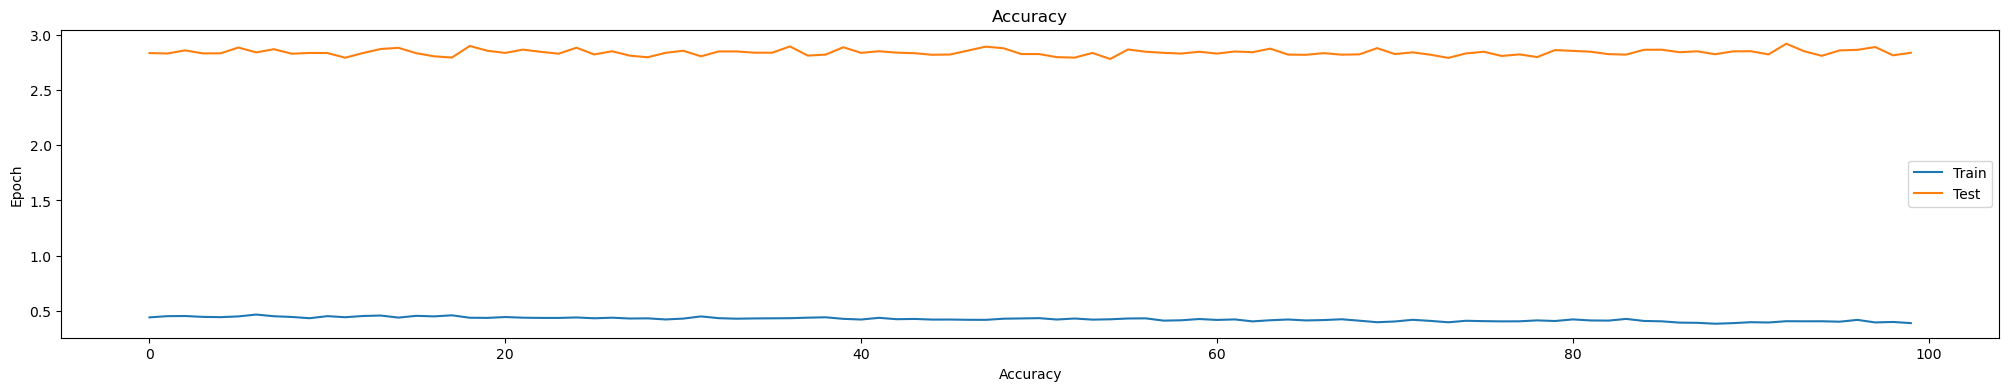

In [44]:
fig, ax = plt.subplots(figsize=(25, 4))
ax.plot(history.history['loss'])
ax.plot(history.history['val_loss'])
ax.set_title('Accuracy')
ax.set_xlabel('Accuracy')
ax.set_ylabel('Epoch')

plt.legend(['Train', 'Test'])
plt.show()

In [35]:
y_pred = model.predict(X_test, verbose = 0)

print("R Squared Error    :",round(r2_score(y_test, y_pred), 2))
print("Mean Squared Error :",round(mean_squared_error(y_test, y_pred), 2))

R Squared Error    : 0.63
Mean Squared Error : 20.95


In [36]:
train_predictions = model.predict(X_test, verbose=0).flatten()

train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_test})
train_results['Diff'] = abs(train_results['Actuals'] - train_results['Train Predictions'])
print(train_results.head(5))
print(train_results['Diff'].mean(), '-', (train_results['Diff'].sum()))

       Train Predictions  Actuals      Diff
211            61.104187    66.58  5.475813
29747          60.951832    61.42  0.468168
11171          58.099155    62.34  4.240845
31621          47.476521    47.58  0.103479
25937          46.923855    47.09  0.166145
2.885994211464409 - 10761.87241455078


In [38]:
pred_df = data.copy()

# x_test = pred_df.drop(columns=['DateTime', 'SMPEP2'])
x_test = pred_df[["Day", "Month", 'Holiday', 'HolidayFlag',
        "ForecastWindProduction", "SystemLoadEA", 
        "SMPEA", "ORKTemperature", "ORKWindspeed", "CO2Intensity", 
        "ActualWindProduction", "SystemLoadEP2"]]
train_predictions = model.predict(x_test, verbose=0).flatten()

pred_df['Prediction'] = train_predictions
pred_df

,DateTime,Holiday,HolidayFlag,DayOfWeek,WeekOfYear,Day,Month,Year,PeriodOfDay,ForecastWindProduction,SystemLoadEA,SMPEA,ORKTemperature,ORKWindspeed,CO2Intensity,ActualWindProduction,SystemLoadEP2,SMPEP2,Prediction
0,01/11/2011 00:00,11,0,1,44,1,11,2011,0,315.31,3388.77,49.26,6.0,9.3,600.71,356.0,3159.60,54.32,57.716805
1,01/11/2011 00:30,11,0,1,44,1,11,2011,1,321.80,3196.66,49.26,6.0,11.1,605.42,317.0,2973.01,54.23,57.281536
2,01/11/2011 01:00,11,0,1,44,1,11,2011,2,328.57,3060.71,49.10,5.0,11.1,589.97,311.0,2834.00,54.23,57.436443
3,01/11/2011 01:30,11,0,1,44,1,11,2011,3,335.60,2945.56,48.04,6.0,9.3,585.94,313.0,2725.99,53.47,57.341980
12,01/11/2011 06:00,11,0,1,44,1,11,2011,12,339.22,3039.67,44.31,5.0,3.7,556.14,383.0,2842.19,51.45,62.123222
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38005,31/12/2013 19:30,10,1,1,1,31,12,2013,39,1136.22,4286.95,74.84,6.0,22.2,311.24,1085.0,4447.42,62.05,-26.835670
38006,31/12/2013 20:00,10,1,1,1,31,12,2013,40,1160.57,4188.85,66.08,5.0,18.5,262.97,1143.0,4207.57,62.05,-27.030998
38007,31/12/2013 20:30,10,1,1,1,31,12,2013,41,1183.58,4122.26,65.39,5.0,20.4,264.71,941.0,4051.01,59.48,-26.955067
38008,31/12/2013 21:00,10,1,1,1,31,12,2013,42,1204.71,4000.49,63.32,5.0,18.5,266.03,913.0,3856.20,50.60,-27.050983
